# Univariate time series classification with sktime

In this notebook, we will use sktime for univariate time series classification. Here, we have a single time series variable and an associated label for multiple instances. The goal is to find a classifier that can learn the relationship between time series and label and accurately predict the label of new series.

When you have multiple time series variables and want to learn the relationship between them and a label, you can take a look at our [multivariate time series classification notebook](https://github.com/alan-turing-institute/sktime/blob/master/examples/03_classification_multivariate.ipynb).

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.datasets import load_arrow_head
from sktime.series_as_features.compose import FeatureUnion
from sktime.transformers.series_as_features.compose import RowTransformer
from sktime.transformers.series_as_features.reduce import Tabularizer
from sktime.transformers.series_as_features.segment import \
    RandomIntervalSegmenter
from sktime.utils.time_series import time_series_slope
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf

## Load data

In this notebook, we use the [arrow head problem](https://timeseriesclassification.com/description.php?Dataset=ArrowHead).

The arrowhead dataset consists of outlines of the images of arrow heads. The classification of projectile points is an important topic in anthropology. The classes are based on shape distinctions such as the presence and location of a notch in the arrow.

<img src="./img/arrow-heads.png" width="400" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="400" alt="from shapes to time series">

### Data representation
Throughout sktime, the expected data format is a `pd.DataFrame`, but in a slighly unusual format. A single column can contain not only primitives (floats, integers or strings), but also entire time series in form of a `pd.Series` or `np.array`.

For more details on our choice of data container, see this [wiki entry](https://github.com/alan-turing-institute/sktime/wiki/Time-series-data-container).

In [2]:
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


In [3]:
# univariate time series input data
X_train.head()

,dim_0
62,0 -1.9471 1 -1.9405 2 -1.9224 3 ...
73,0 -1.8132 1 -1.8255 2 -1.8166 3 ...
45,0 -1.3076 1 -1.3171 2 -1.3128 3 ...
97,0 -2.1468 1 -2.1483 2 -2.1332 3 ...
15,0 -2.1645 1 -2.1785 2 -2.0660 3 ...


In [4]:
# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2'] [55 50 53]


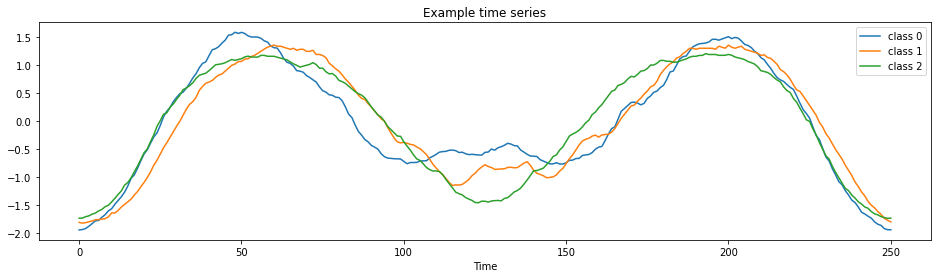

In [5]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

## Why not just use scikit-learn?

We can still use scikit-learn, but using scikit-learn comes with some implicit modelling choices.

### Reduction: from time-series classification to tabular classification

To use scikit-learn, we have to convert the data into the required tabular format. There are different ways we can do that:

#### Treating time points as separate features (tabularisation)
Alternatively, we could bin and aggregate observations in time bins of different length.

In [6]:
from sktime.utils.data_container import tabularize
from sklearn.ensemble import RandomForestClassifier

X_train_tab = tabularize(X_train)
X_test_tab = tabularize(X_test)

X_train_tab.head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
62,-1.9471,-1.9405,-1.9224,-1.8804,-1.8347,-1.7847,-1.7769,-1.7195,-1.6755,-1.6061,...,-1.6306,-1.6618,-1.7016,-1.7360,-1.8031,-1.8445,-1.8665,-1.9226,-1.9435,-1.9442
73,-1.8132,-1.8255,-1.8166,-1.8025,-1.7866,-1.7659,-1.7616,-1.7547,-1.7455,-1.7145,...,-1.2668,-1.3390,-1.4362,-1.5041,-1.5512,-1.6177,-1.6687,-1.7403,-1.7732,-1.8038
45,-1.3076,-1.3171,-1.3128,-1.3306,-1.3074,-1.2611,-1.2622,-1.2781,-1.2118,-1.2266,...,-1.1091,-1.1644,-1.1687,-1.2175,-1.2885,-1.3328,-1.3291,-1.3191,-1.3306,-1.3268
97,-2.1468,-2.1483,-2.1332,-2.0753,-2.0414,-1.9828,-1.9368,-1.8607,-1.7994,-1.7104,...,-1.6146,-1.6933,-1.8121,-1.8732,-1.9349,-1.9978,-2.0563,-2.0753,-2.1191,-2.1440
15,-2.1645,-2.1785,-2.0660,-2.0461,-1.9791,-1.8481,-1.7501,-1.7210,-1.6390,-1.5723,...,-1.6703,-1.7837,-1.8633,-1.9639,-2.0125,-2.0642,-2.0725,-2.1175,-2.0920,-2.1318


In [7]:
# let's get a baseline for comparison
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train_tab, y_train)
classifier.score(X_test_tab, y_test)

0.49056603773584906

In [8]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_tab, y_train)
y_pred = classifier.predict(X_test_tab)
accuracy_score(y_test, y_pred)

0.9056603773584906

In [9]:
# with sktime, we can write this as a pipeline
from sktime.transformers.series_as_features.reduce import Tabularizer
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(Tabularizer(), RandomForestClassifier())
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.8867924528301887

What's the implicit modelling choice here?

> We treat each observation as a separate feature and thus ignore they are ordered in time. A tabular algorithm cannot make use of the fact that features are ordered in time, i.e. if we changed the order of the features, the fitted model and predictions wouldn't change. Sometimes this works well, sometimes it doesn't. 

#### Feature extraction

Another modelling choice: we could extract features from the time series and then use the features to fit our tabular classifier. Here we use [tsfresh](https://tsfresh.readthedocs.io) for automatic feature extraction.

In [10]:
from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor

transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train)
extracted_features.head()

/Users/travis/build/alan-turing-institute/sktime/sktime/transformers/series_as_features/summarize/_tsfresh.py:150: UserWarning: Found non-unique index, replaced with unique index.
  warn("Found non-unique index, replaced with unique index.")


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 57.55it/s]

variable,dim_0__length,dim_0__maximum,dim_0__mean,dim_0__median,dim_0__minimum,dim_0__standard_deviation,dim_0__sum_values,dim_0__variance
0,251.0,1.59340,1.215139e-06,-0.207150,-1.9471,0.998005,0.000305,0.996014
1,251.0,1.36240,5.976096e-08,-0.020305,-1.8255,0.998005,0.000015,0.996013
2,251.0,1.32890,-1.394422e-06,0.187990,-1.7786,0.998006,-0.000350,0.996015
3,251.0,0.95877,1.247012e-06,0.463790,-2.1483,0.998005,0.000313,0.996013
4,251.0,1.65540,4.501992e-07,0.215190,-2.1785,0.998006,0.000113,0.996017


In [11]:
classifier = make_pipeline(TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier())
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

/Users/travis/build/alan-turing-institute/sktime/sktime/transformers/series_as_features/summarize/_tsfresh.py:150: UserWarning: Found non-unique index, replaced with unique index.
  warn("Found non-unique index, replaced with unique index.")


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:04<00:19,  4.81s/it]

Feature Extraction:  40%|████      | 2/5 [00:09<00:14,  4.67s/it]

Feature Extraction:  60%|██████    | 3/5 [00:13<00:09,  4.62s/it]

Feature Extraction:  80%|████████  | 4/5 [00:18<00:04,  4.56s/it]

Feature Extraction: 100%|██████████| 5/5 [00:22<00:00,  4.44s/it]

Feature Extraction: 100%|██████████| 5/5 [00:22<00:00,  4.44s/it]

/Users/travis/build/alan-turing-institute/sktime/sktime/transformers/series_as_features/summarize/_tsfresh.py:150: UserWarning: Found non-unique index, replaced with unique index.
  warn("Found non-unique index, replaced with unique index.")


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:01<00:06,  1.58s/it]

Feature Extraction:  40%|████      | 2/5 [00:03<00:04,  1.57s/it]

Feature Extraction:  60%|██████    | 3/5 [00:04<00:03,  1.56s/it]

Feature Extraction:  80%|████████  | 4/5 [00:06<00:01,  1.56s/it]

Feature Extraction: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]

Feature Extraction: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

0.9245283018867925

What's the implicit modelling choice here?

> Instead of working in the domain of the time series, we extract features from time series and choose to work in the domain of the features. Again, sometimes this works well, sometimes it doesn't. The main difficulty is finding discriminative features for the classification problem. 


## Time series classification with sktime
sktime has a number of specialised time series algorithms. 

### Time series forest
Time series forest is a modification of the random forest algorithm to the time series setting: 

1. Split the series into multiple random intervals,
2. Extract features (mean, standard deviation and slope) from each interval,
3. Train a decision tree on the extracted features,
4. Ensemble steps 1 - 3.


For more details, take a look at the [paper](https://www.sciencedirect.com/science/article/pii/S0020025513001473).

In sktime, we can write:

In [12]:
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor

steps = [
    ('extract', RandomIntervalFeatureExtractor(n_intervals='sqrt', features=[np.mean, np.std, time_series_slope])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)

To better understand the algorithm, we could write it in an even more modular way:

```python
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals='sqrt')),
    ('transform', FeatureUnion([
        ('mean', RowTransformer(FunctionTransformer(func=np.mean, validate=False))),
        ('std', RowTransformer(FunctionTransformer(func=np.std, validate=False))),
        ('slope', RowTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
    ])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)
```

We can direclty fit and evaluate the single time series tree (which is simply a pipeline).

In [13]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.7735849056603774

For time series forest, we can simply use the single tree as the base estimator in the forest ensemble.

In [14]:
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.8679245283018868

We can also obtain feature importances for the different features and intervals that the algorithms looked at and plot them in a feature importance graph over time.

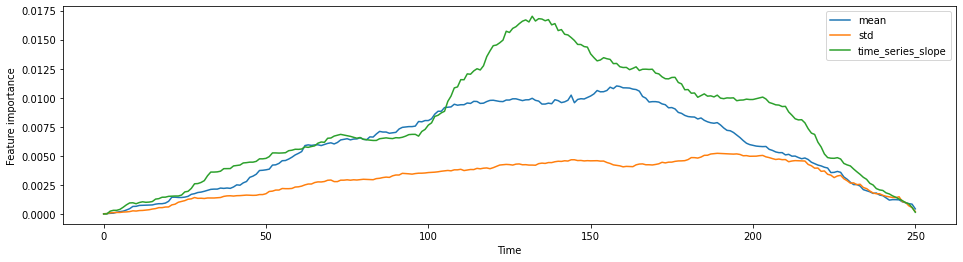

In [15]:
fi = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance");

### RISE

Another popular variant of time series forest is the so-called Random Interval Spectral Ensemble (RISE), which makes use of several series-to-series feature extraction transformers, including:

* Fitted auto-regressive coefficients,
* Estimated autocorrelation coefficients,
* Power spectrum coefficients.

In [16]:
def ar_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    lags = np.minimum(len(x) - 1, maxlag) // 2
    model = AutoReg(endog=x, trend="n", lags=lags)
    return model.fit().params.ravel()

def acf_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    nlags = np.minimum(len(x) - 1, maxlag)
    return acf(x, nlags=nlags, fft=True).ravel()

def powerspectrum(x):
    x = np.asarray(x).ravel()
    fft = np.fft.fft(x)
    ps = fft.real * fft.real + fft.imag * fft.imag
    return ps[:ps.shape[0] // 2].ravel()

The full pipeline of a single tree in RISE is then specified as follows:

In [17]:
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals=1, min_length=5)),
    ('transform', FeatureUnion([
        ('ar', RowTransformer(FunctionTransformer(func=ar_coefs, validate=False))),
        ('acf', RowTransformer(FunctionTransformer(func=acf_coefs, validate=False))),
        ('ps', RowTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
    ])),
    ('tabularise', Tabularizer()),
    ('clf', DecisionTreeClassifier())
]
rise_tree = Pipeline(steps)

rise = TimeSeriesForestClassifier(estimator=rise_tree, n_estimators=10)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.8113207547169812

### K-nearest-neighbours classifier for time series
For time series, the most popular k-nearest-neighbours algorithm is based on [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) (dtw) distance measure.

<img src="img/dtw.png" width=500 />

Here we look at the [BasicMotions data set](http://www.timeseriesclassification.com/description.php?Dataset=BasicMotions). The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

In [18]:
from sktime.datasets import load_basic_motions
X, y = load_basic_motions(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, [0]], y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 1) (60,) (20, 1) (20,)


In [19]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['badminton' 'running' 'standing' 'walking'] [12 15 17 16]


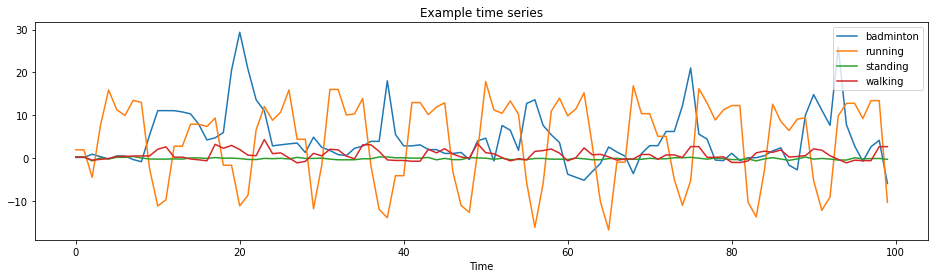

In [20]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=label)
plt.legend()
ax.set(title="Example time series", xlabel="Time");

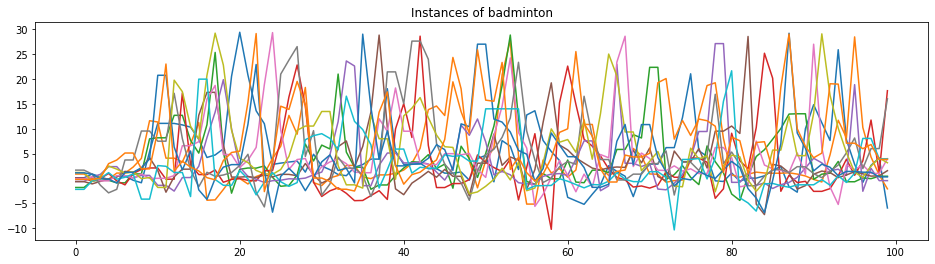

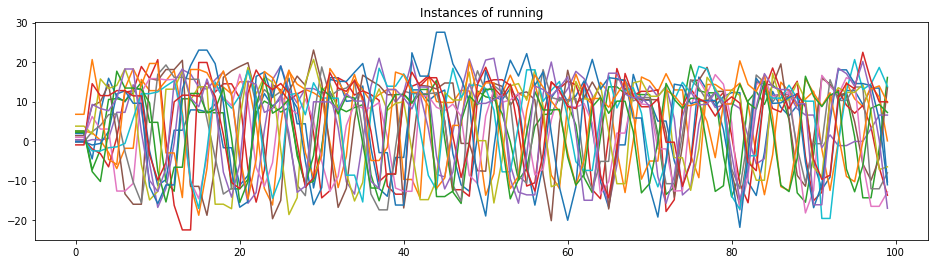

In [21]:
for label in labels[:2]:
    fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
    for instance in X_train.loc[y_train == label, "dim_0"]:
        ax.plot(instance)
    ax.set(title=f"Instances of {label}")

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = make_pipeline(
    Tabularizer(),
    KNeighborsClassifier(n_neighbors=1, metric="euclidean"))
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6

In [23]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

1.0

### Other classifiers
To find out what other algorithms we have implemented in sktime, you can use our utility function:

In [24]:
from sktime.utils import all_estimators
all_estimators(estimator_type="classifier")

[('BOSSEnsemble', sktime.classification.dictionary_based._boss.BOSSEnsemble),
 ('BOSSIndividual',
  sktime.classification.dictionary_based._boss.BOSSIndividual),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('ElasticEnsemble',
  sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('KNeighborsTimeSeriesClassifier',
  sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('MrSEQLClassifier',
  sktime.classification.shapelet_based.mrseql.mrseql.MrSEQLClassifier),
 ('ProximityForest',
  sktime.classification.distance_based._proximity_forest.ProximityForest),
 ('ProximityStump',
  sktime.classification.distance_based._proximity_forest.ProximityStump),
 ('ProximityTree',
  sktime.classification.distance_based._proximity_forest.ProximityTree),
 ('RandomIntervalSpectralForest',
  sktime.classification.frequency_based._rise.RandomIntervalSpectralForest),
 ('ShapeletTransfo

## Extra resources

### Multivariate time series classification
* When you have multiple time series variables and want to learn the relationship between them and a label, you can take a look at our [multivariate time series classification notebook](https://github.com/alan-turing-institute/sktime/blob/master/examples/03_classification_multivariate.ipynb).

### Cutting-edge research and benchmarking
* For time-series classification data sets and Java-based methods, check out [timeseriesclassification.com](http://www.timeseriesclassification.com)
* For a comparative benchmarking studies, check out 
    * [Bagnall, Anthony, et al. "The great time series classification bake off: a review and experimental evaluation of recent algorithmic advances." Data Mining and Knowledge Discovery 31.3 (2017): 606-660.](https://www.researchgate.net/profile/Anthony_Bagnall/publication/301856632_The_Great_Time_Series_Classification_Bake_Off_An_Experimental_Evaluation_of_Recently_Proposed_Algorithms_Extended_Version/links/579b580e08ae80bf6ea33d12.pdf) and 
    * [Fawaz, Hassan Ismail, et al. "Deep learning for time series classification: a review." Data Mining and Knowledge Discovery 33.4 (2019): 917-963.](https://arxiv.org/pdf/1809.04356)

### Deep learning 
* For deep-learning, check out sktime's companion packages: [sktime-dl](https://github.com/sktime/sktime-dl)

### Time series regression
* sktime also supports time series regression, where the only difference is that the target variables is continuous and not discrete. 